<a href="https://www.kaggle.com/rsizem2/tps-11-21-gradient-boosting-baselines-w-gpu?scriptVersionId=85029116" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Gradient Boosting Baselines

In this notebook we get baselines for the GPU enabled LightGBM, XGBoost and CatBoost models. We mostly leave our settings as default and do not preprocess the training data with the exception of the following:

* Downcast our data to it's lowest subtype (e.g. `float64` to `float32`)
* We set `n_estimators = 10000` and `learning_rate = 0.016` with early stopping.
* Enable training on GPU

We change the learning rates so that all the models considered are consistent with what CatBoost chooses by default.

**Note:** The performance of one model relative to another does not indicate that it will perform better than the other after we tweak more parameters or perform feature engineering.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 5
ETA = 0.016
NUM_TREES = 10000
EARLY_STOP = 150

## Install GPU-enabled LightGBM

We follow [this notebook](https://www.kaggle.com/abhishek/running-lightgbm-on-gpu/notebook) for installing GPU-enabled LightGBM.

In [2]:
# Remove CPU only verson
!pip uninstall -y lightgbm

# Install boost development library
!apt-get install -y libboost-all-dev

# Clone LightGBM repository
!git clone --recursive https://github.com/Microsoft/LightGBM

Found existing installation: lightgbm 3.2.1
Uninstalling lightgbm-3.2.1:
  Successfully uninstalled lightgbm-3.2.1



The following additional packages will be installed:
  autotools-dev dh-python file gir1.2-harfbuzz-0.0 ibverbs-providers
  icu-devtools libboost-atomic-dev libboost-atomic1.65-dev
  libboost-atomic1.65.1 libboost-chrono-dev libboost-chrono1.65-dev
  libboost-chrono1.65.1 libboost-container-dev libboost-container1.65-dev
  libboost-container1.65.1 libboost-context-dev libboost-context1.65-dev
  libboost-context1.65.1 libboost-coroutine-dev libboost-coroutine1.65-dev
  libboost-coroutine1.65.1 libboost-date-time-dev libboost-date-time1.65-dev
  libboost-date-time1.65.1 libboost-exception-dev libboost-exception1.65-dev
  libboost-fiber-dev libboost-fiber1.65-dev libboost-fiber1.65.1
  libboost-graph-dev libboost-graph-parallel-dev
  libboost-graph-parallel1.65-dev libboost-graph-parallel1.65.1
  libboost-graph1.65-dev libboost-graph1.65.1 libboost-iostreams-dev
  libboost

In [3]:
%%bash
cd LightGBM
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking for CL_VERSION_1_2 - found
-- Found OpenCL: /usr/local/cuda/lib64/libOpenCL.so (found vers

In [4]:
# Reinstall LightGBM
!cd LightGBM/python-package/;python3 setup.py install --precompile

# Cleanup
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/dask.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.e

## Imports

In [5]:
# General Imports
import numpy as np
import pandas as pd
import time
import gc

# Models
import xgboost
import lightgbm
import catboost
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Prepare Data

In [6]:
%%time

# Load data
train = pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv')

# Save feature columns
features = [x for x in train.columns if x not in ['id', 'target', 'kfold']]

CPU times: user 18.9 s, sys: 1.09 s, total: 19.9 s
Wall time: 27.4 s


In [7]:
# Downcast float/int datatypes
def reduce_memory_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
        
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [8]:
%%time

# Downcast data
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Mem. usage decreased to 231.74 Mb (50.4% reduction)
Mem. usage decreased to 208.05 Mb (50.0% reduction)
CPU times: user 5.39 s, sys: 7.94 s, total: 13.3 s
Wall time: 13.4 s


In [9]:
# Create cross-validation scheme
train['kfold'] = -1
skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['target'])):
    train['kfold'].iloc[valid_idx] = fold

# CatBoost Baseline

In [10]:
# CatBoost parameters
catboost_params = {
    'random_state': RANDOM_SEED,
    'n_estimators': NUM_TREES,
    #'learning_rate': ETA,
    'eval_metric': 'AUC:hints=skip_train~false',
    'task_type': 'GPU',
}

In [11]:
def train_catboost(model_params = {}, fit_params = {}):
    
    # Store the predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')

    # Stratified k-fold cross-validation
    for fold in range(NUM_FOLDS):
        
        # Training and Validation Sets
        X_train, y_train = train[train.kfold != fold][features], train[train.kfold != fold]['target']
        X_valid, y_valid = train[train.kfold == fold][features], train[train.kfold == fold]['target']
        X_test = test[features]
        
        start = time.time()
        
        # Define Model
        model = CatBoostClassifier(**{**catboost_params, **model_params})
        gc.collect()
        
        model.fit(
            X_train, y_train,
            verbose = False,
            eval_set = [(X_valid, y_valid)],
            early_stopping_rounds = EARLY_STOP,
            use_best_model = True,
            **fit_params
        )
        
        # validation and test predictions
        valid_preds = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        oof_preds[train.kfold == fold] = valid_preds
        
        # fold auc score
        fold_auc = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC):', fold_auc)
        scores[fold] = fold_auc
        times[fold] = end-start
    
    print("\nAverage AUC:", scores.mean())
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return model, test_preds, oof_preds

In [12]:
# Make CatBoost submission
catb_model, catb_preds, catb_oof = train_catboost()
submission['target'] =  catb_preds
submission.to_csv('catboost_submission.csv', index=False)


Fold 0 (AUC): 0.7484740748643198
Fold 1 (AUC): 0.7490369250289288
Fold 2 (AUC): 0.7466972646813248
Fold 3 (AUC): 0.7487571526852803
Fold 4 (AUC): 0.7474142258548084

Average AUC: 0.7480759286229324
Training Time: 745.49s


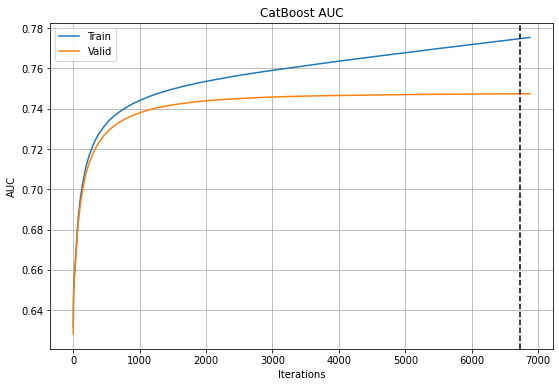

In [13]:
# Get model evaluation results
results = catb_model.get_evals_result()
num_iter = len(results['learn']['AUC'])
x_axis = range(0, num_iter)

# Plot training curve
fig, ax = plt.subplots(figsize = (9,6))
ax.plot(x_axis, results['learn']['AUC'], label='Train')
ax.plot(x_axis, results['validation']['AUC'], label='Valid')
plt.axvline(x=catb_model.get_best_iteration(), color='k', linestyle='--')
ax.legend()
plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.title('CatBoost AUC')
plt.grid(True)
plt.show()

# LightGBM Baseline

In [14]:
# LightGBM parameters
lightgbm_params = {
    'random_state': RANDOM_SEED,
    'n_estimators': NUM_TREES,
    'learning_rate': ETA,
    'verbose': 0,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
}

In [15]:
def train_lightgbm(model_params = {}, fit_params = {}):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    for fold in range(NUM_FOLDS):
        
        # Training and Validation Sets
        X_train, y_train = train[train.kfold != fold][features], train[train.kfold != fold]['target']
        X_valid, y_valid = train[train.kfold == fold][features], train[train.kfold == fold]['target']
        X_test = test[features]
        
        # Define Model
        model = LGBMClassifier(**{**lightgbm_params, **model_params})
        gc.collect()
        
        start = time.time()
        
        model.fit(
            X_train, y_train,
            eval_set = [(X_train, y_train), (X_valid, y_valid)],
            eval_names = ['Train', 'Valid'],
            eval_metric = "auc",
            callbacks = [lightgbm.early_stopping(EARLY_STOP, verbose = False)],
            **fit_params
        )
        
        # validation and test predictions
        valid_preds = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        oof_preds[train.kfold == fold] = valid_preds
        
        # fold auc score
        fold_auc = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC):', fold_auc)
        scores[fold] = fold_auc
        times[fold] = end-start
    
    print("\nAverage AUC:", scores.mean())
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return model, test_preds, oof_preds

In [16]:
# Make LightGBM submission
lgbm_model, lgbm_preds, lgbm_oof = train_lightgbm()
submission['target'] =  lgbm_preds
submission.to_csv('lightgbm_submission.csv', index=False)


Fold 0 (AUC): 0.7458449541074412
Fold 1 (AUC): 0.7465122521321279
Fold 2 (AUC): 0.7441394022697265
Fold 3 (AUC): 0.7462008752247716
Fold 4 (AUC): 0.7442091203630831

Average AUC: 0.7453813208194301
Training Time: 2309.02s


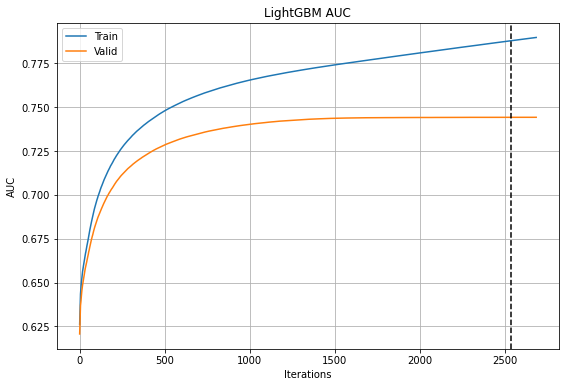

In [17]:
# Get model evaluation results
results = lgbm_model.evals_result_
num_iter = len(results['Train']['auc'])
x_axis = range(0, num_iter)

# Plot training curve
fig, ax = plt.subplots(figsize = (9,6))
ax.plot(x_axis, results['Train']['auc'], label='Train')
ax.plot(x_axis, results['Valid']['auc'], label='Valid')
plt.axvline(x=lgbm_model.best_iteration_, color='k', linestyle='--')
ax.legend()
plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.title('LightGBM AUC')
plt.grid(True)
plt.show()

# XGBoost Baseline (Boosted Trees)

In [18]:
# XGBoost parameters
xgboost_params = {
    'random_state': RANDOM_SEED,
    'n_estimators': NUM_TREES,
    'learning_rate': ETA,
    'tree_method': 'gpu_hist',
    'predictor': "gpu_predictor",
}

In [19]:
def train_xgboost(model_params = {}, fit_params = {}):
    
    # Store the  predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    for fold in range(NUM_FOLDS):
        
        # Training and Validation Sets
        X_train, y_train = train[train.kfold != fold][features], train[train.kfold != fold]['target']
        X_valid, y_valid = train[train.kfold == fold][features], train[train.kfold == fold]['target']
        X_test = test[features]
        
        # Define Model
        model = XGBClassifier(**{**xgboost_params, **model_params})
        gc.collect()
        
        start = time.time()
        
        model.fit(
            X_train, y_train,
            verbose = False,
            eval_set = [(X_train, y_train), (X_valid, y_valid)],
            eval_metric = "auc",
            early_stopping_rounds = EARLY_STOP,
            **fit_params
        )
        
        # validation and test predictions
        valid_preds = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        oof_preds[train.kfold == fold] = valid_preds
        
        # fold auc score
        fold_auc = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC):', fold_auc)
        scores[fold] = fold_auc
        times[fold] = end-start
    
    print("\nAverage AUC:", scores.mean())
    print(f'Training Time: {round(times.sum(), 2)}s')
        
    return model, test_preds, oof_preds

In [20]:
# Make XGBoost submission
xgb_model, xgb_preds, xgb_oof = train_xgboost()
submission['target'] = xgb_preds
submission.to_csv('xgboost_trees_submission.csv', index=False)


Fold 0 (AUC): 0.7448494988356457
Fold 1 (AUC): 0.7460669415791603
Fold 2 (AUC): 0.7433436469457699
Fold 3 (AUC): 0.7457622613332482
Fold 4 (AUC): 0.7439237095908418

Average AUC: 0.7447892116569331
Training Time: 243.56s


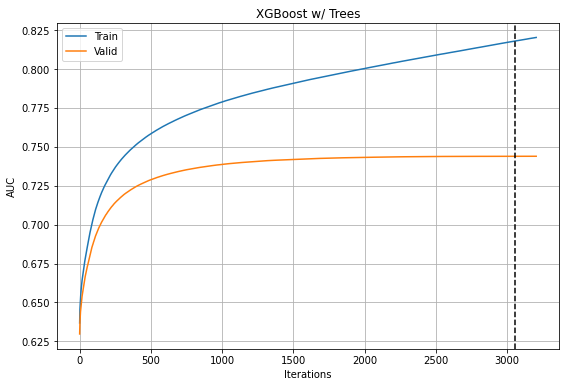

In [21]:
# Get model evaluation results
results = xgb_model.evals_result()
num_iter = len(results['validation_0']['auc'])
x_axis = range(0, num_iter)

# Plot training curve
fig, ax = plt.subplots(figsize = (9,6))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Valid')
plt.axvline(x=xgb_model.best_iteration, color='k', linestyle='--')
ax.legend()
plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.title('XGBoost w/ Trees')
plt.grid(True)
plt.show()

# XGBoost (Linear Boosting)

In [22]:
# XGBoost parameters
xgboost_params = {
    'random_state': RANDOM_SEED,
    'booster': "gblinear",
}

In [23]:
def train_xgboost(model_params = {}, fit_params = {}):
    
    # Store the  predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    for fold in range(NUM_FOLDS):
        
        # Training and Validation Sets
        X_train, y_train = train[train.kfold != fold][features], train[train.kfold != fold]['target']
        X_valid, y_valid = train[train.kfold == fold][features], train[train.kfold == fold]['target']
        X_test = test[features]
        
        # Define Model
        model = XGBClassifier(**{**xgboost_params, **model_params})
        gc.collect()
        
        start = time.time()
        
        model.fit(
            X_train, y_train,
            verbose = False,
            eval_set = [(X_train, y_train), (X_valid, y_valid)],
            eval_metric = "auc",
            early_stopping_rounds = EARLY_STOP,
            **fit_params
        )
        
        # validation and test predictions
        valid_preds = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        oof_preds[train.kfold == fold] = valid_preds
        
        # fold auc score
        fold_auc = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC):', fold_auc)
        scores[fold] = fold_auc
        times[fold] = end-start
    
    print("\nAverage AUC:", scores.mean())
    print(f'Training Time: {round(times.sum(), 2)}s')
        
    return model, test_preds, oof_preds

In [24]:
# Make XGBoost submission
xgb_model, xgb_preds, xgb_oof = train_xgboost()
submission['target'] = xgb_preds
submission.to_csv('xgboost_linear_submission.csv', index=False)


Fold 0 (AUC): 0.7485084441328074
Fold 1 (AUC): 0.7496327066155111
Fold 2 (AUC): 0.7472015198570233
Fold 3 (AUC): 0.7493416193046447
Fold 4 (AUC): 0.7477483763235009

Average AUC: 0.7484865332466974
Training Time: 215.61s


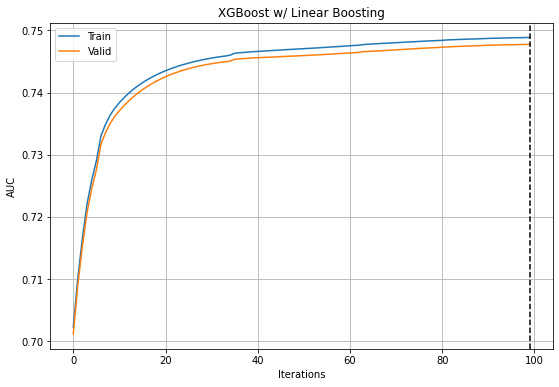

In [25]:
# Get model evaluation results
results = xgb_model.evals_result()
num_iter = len(results['validation_0']['auc'])
x_axis = range(0, num_iter)

# Plot training curve
fig, ax = plt.subplots(figsize = (9,6))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Valid')
plt.axvline(x=xgb_model.best_iteration, color='k', linestyle='--')
ax.legend()
plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.title('XGBoost w/ Linear Boosting')
plt.grid(True)
plt.show()